In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB2
from tensorflow.keras.models import Sequential
import glob
import os.path
import cv2
import seaborn as sns
import pandas as pd
import keras.callbacks as callbacks
import uuid

In [2]:
IMG_SIZE = 224

In [3]:
classes = ['credit_card', 'passport', 'receipt']

ds_cfg = dict(
    labels='inferred',
    label_mode="int",
    class_names=classes,
    color_mode='rgb',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=64,
    shuffle=True,
    seed=123,
    validation_split=0.3,
)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './notebooks/datasets/documents/raw',
    subset="training",
    **ds_cfg
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './notebooks/datasets/documents/raw',
    subset="validation",
    **ds_cfg
)

Found 1067 files belonging to 3 classes.
Using 747 files for training.
Found 1067 files belonging to 3 classes.
Using 320 files for validation.


In [14]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)

data_augmentation = keras.Sequential([
    layers.RandomBrightness(factor=0.1),
    layers.RandomFlip("horizontal",input_shape=img_shape),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

model = Sequential([
  layers.Rescaling(1./255, input_shape=img_shape),
  
  layers.Conv2D(16, 3, padding='same'),
  layers.ReLU(),
  layers.BatchNormalization(momentum=0.1),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same'),
  layers.ReLU(),
  layers.BatchNormalization(momentum=0.1),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same'),
  layers.ReLU(),
  layers.BatchNormalization(momentum=0.1),
  layers.MaxPooling2D(),

  layers.Dropout(0.28),

  layers.Flatten(),
  
  layers.Dense(128),
  layers.ReLU(),

  layers.Dense(len(classes))
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/Users/piotrpersona/anaconda3/envs/cnn/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
run_id = uuid.uuid4()
train_dir = f'./notebooks/models/training/{run_id}'
log_dir = f'{train_dir}/logs'
print(f'Training model with run_id: {run_id}, dir: {train_dir}, log_dir: {log_dir}')

callback = [
    callbacks.EarlyStopping(patience=20),
    callbacks.ModelCheckpoint(filepath=f'{train_dir}/model.keras'),
    callbacks.TensorBoard(log_dir=log_dir)
]

epochs = 50

train_cfg = dict(
    epochs=epochs,
    validation_data=validation_ds,
    callbacks=callback
)

history = model.fit(train_ds, **train_cfg)

Training model with run_id: f98417ba-a865-4c17-9ffb-77dbc68d7c2b, dir: ./notebooks/models/training/f98417ba-a865-4c17-9ffb-77dbc68d7c2b, log_dir: ./notebooks/models/training/f98417ba-a865-4c17-9ffb-77dbc68d7c2b/logs
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 753ms/step - accuracy: 0.5999 - loss: 5.7215 - val_accuracy: 0.6781 - val_loss: 3.9250
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 738ms/step - accuracy: 0.7891 - loss: 1.7520 - val_accuracy: 0.8375 - val_loss: 1.8633
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 720ms/step - accuracy: 0.9110 - loss: 0.3299 - val_accuracy: 0.8531 - val_loss: 0.9532
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 774ms/step - accuracy: 0.9539 - loss: 0.1516 - val_accuracy: 0.8906 - val_loss: 1.1802
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 826ms/step - accuracy: 0.9788 - loss: 0.0711 - val_accuracy: 0.8813 - val_loss: 1.3150
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 730ms/step - accuracy: 0.9870 - loss: 0.0455 - val_accuracy: 0.8625 - val_loss: 0.8081
Epoch 7/50
12/

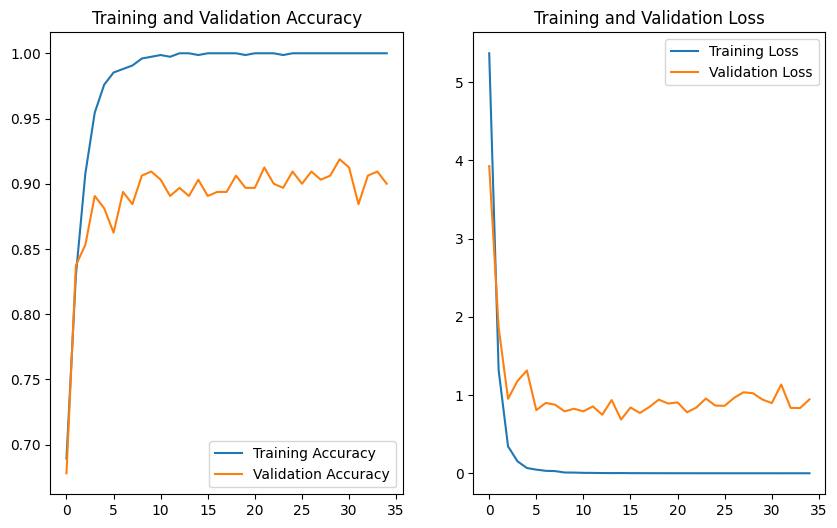

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [87]:
predictions_result = []
for image_file in glob.glob("./notebooks/datasets/documents/val/*/*"):    
    img = tf.keras.utils.load_img(image_file)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predictions_result.append(dict(
        label=image_file.split("/")[-2],
        predicted_label=classes[np.argmax(score)],
        score=100 * np.max(score),
    ))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

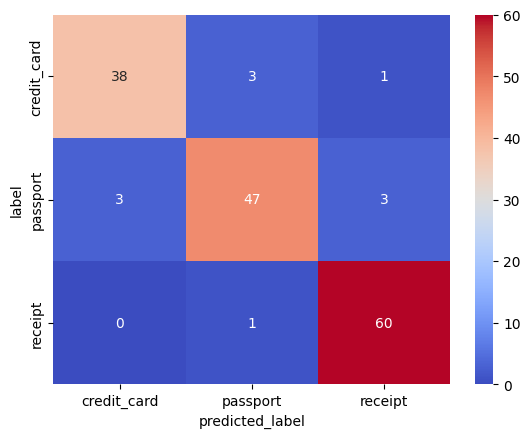

In [84]:
def present_confusion_matrix(predictions_result):
    confusion_matrix = np.zeros(shape=(len(classes), len(classes)))
    for pred in predictions_result:
        pred_label = np.where(np.array(classes) == pred['predicted_label'])[0][0]
        label = np.where(np.array(classes) == pred['label'])[0][0]
        confusion_matrix[label][pred_label] += 1
    cm_df = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
    ax = sns.heatmap(cm_df, annot=True, cmap="coolwarm")
    ax.set_ylabel('label')
    ax.set_xlabel('predicted_label')
    
present_confusion_matrix(predictions_result)

In [56]:
model_name = f'cnn-e{epochs}-val{val_acc[-1]:.2f}'
model.save(f'./notebooks/models/{model_name}.keras')

In [88]:
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=f'./notebooks/models/{model_name}.onnx')

In [90]:
output_names = [n.name for n in model_proto.graph.output]

In [97]:
import onnxruntime as ort

session = ort.InferenceSession(f'./notebooks/models/{model_name}.onnx', providers = ['CPUExecutionProvider'])
input_name = session.get_inputs()[0].name

onnx_predictions_result = []
for image_file in glob.glob("./notebooks/datasets/documents/val/*/*"):    
    img = tf.keras.utils.load_img(image_file)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = session.run(output_names, {input_name: img_array.numpy()})
    score = tf.nn.softmax(predictions[0])
    onnx_predictions_result.append(dict(
        label=image_file.split("/")[-2],
        predicted_label=classes[np.argmax(score)],
        score=100 * np.max(score),
    ))

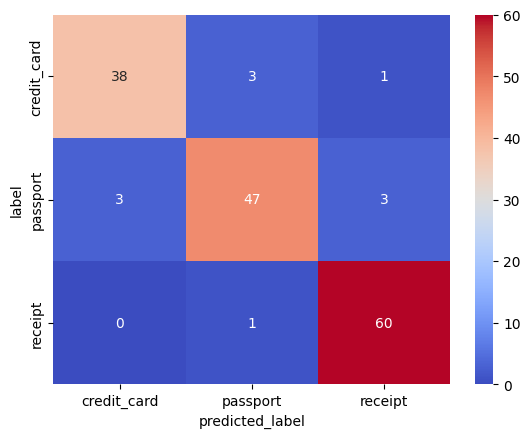

In [98]:
present_confusion_matrix(onnx_predictions_result)